Refs
- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
- https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [162]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [163]:
train_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [164]:
test_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [165]:
print(f'Shape of train data {train_df.shape}')
print(f'Shape of test data {test_df.shape}')

Shape of train data (1460, 81)
Shape of test data (1459, 80)


In [166]:
y_train = train_df['SalePrice']

In [167]:
X_train = train_df.drop('SalePrice', axis=1)

In [168]:
print(f'Shape of train data {X_train.shape}')
print(f'Shape of test data {test_df.shape}')

Shape of train data (1460, 80)
Shape of test data (1459, 80)


In [169]:
master_df = pd.concat([X_train, test_df], axis='rows')
master_df.shape

(2919, 80)

In [170]:
# would need Id in submission
submission = test_df['Id']

master_df.drop('Id', axis=1, inplace=True)
master_df.shape

(2919, 79)

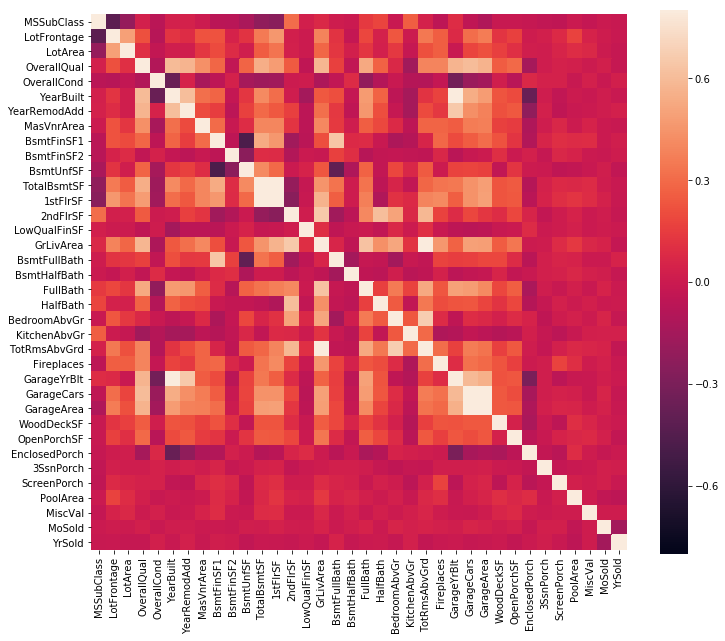

In [171]:
# Understanding and visualization
corr = master_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, vmax=.8, vmin=-0.8, square=True)
plt.show()

In [172]:
# handle columns with high collinearity
corr_unstacked = corr.abs().unstack()
pairs = corr_unstacked[(corr_unstacked > 0.8) & (corr_unstacked < 1)]
pairs

YearBuilt     GarageYrBlt     0.834812
TotalBsmtSF   1stFlrSF        0.801670
1stFlrSF      TotalBsmtSF     0.801670
GrLivArea     TotRmsAbvGrd    0.808354
TotRmsAbvGrd  GrLivArea       0.808354
GarageYrBlt   YearBuilt       0.834812
GarageCars    GarageArea      0.889700
GarageArea    GarageCars      0.889700
dtype: float64

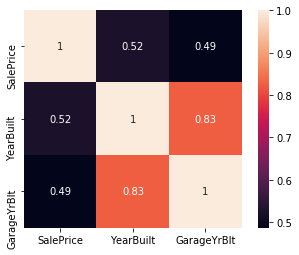

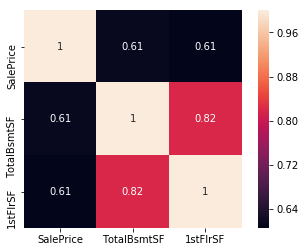

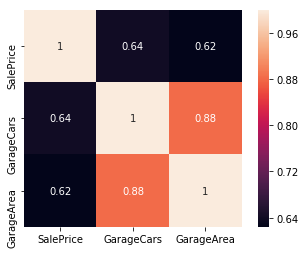

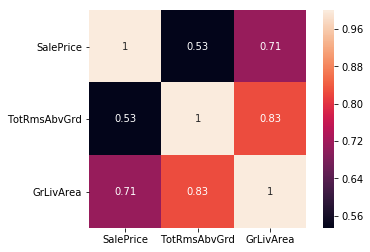

In [173]:
# we will look at thier correlation with price and drop the ones which are less correlated
sns.heatmap(train_df[['SalePrice', 'YearBuilt', 'GarageYrBlt']].corr(), annot=True, square=True)
plt.show()

sns.heatmap(train_df[['SalePrice', 'TotalBsmtSF', '1stFlrSF']].corr(), annot=True, square=True)
plt.show()

sns.heatmap(train_df[['SalePrice', 'GarageCars', 'GarageArea']].corr(), annot=True, square=True)
plt.show()

sns.heatmap(train_df[['SalePrice', 'TotRmsAbvGrd', 'GrLivArea']].corr(), annot=True, square=True)
plt.show()

In [174]:
# drop GarageYrBlt, 1stFlrSF, GarageCars and TotRmsAbvGrd
master_df.drop(columns=['GarageYrBlt', '1stFlrSF', 'GarageCars', 'TotRmsAbvGrd'], inplace=True)
master_df.shape

(2919, 75)

In [175]:
def print_missing(df):
    cols = list(df.columns[(df.isnull().sum() / df.shape[0]) > 0])
    print((df[cols].isnull().sum() / df.shape[0]).sort_values(ascending=False))
    
print_missing(master_df)

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageQual      0.054471
GarageFinish    0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
Utilities       0.000685
BsmtFullBath    0.000685
Functional      0.000685
BsmtHalfBath    0.000685
Exterior2nd     0.000343
Exterior1st     0.000343
SaleType        0.000343
BsmtFinSF1      0.000343
BsmtFinSF2      0.000343
TotalBsmtSF     0.000343
Electrical      0.000343
KitchenQual     0.000343
GarageArea      0.000343
BsmtUnfSF       0.000343
dtype: float64


count     2918
unique       9
top         WD
freq      2525
Name: SaleType, dtype: object


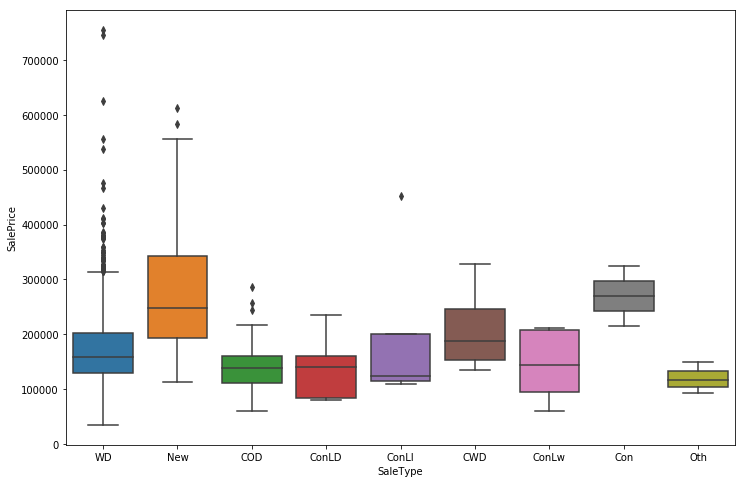

In [176]:
# Consider SaleType
print(master_df['SaleType'].describe())

plt.figure(figsize=(12, 8))
sns.boxplot(x='SaleType', y='SalePrice', data=train_df)
plt.show()

# fill with most freq
master_df['SaleType'].fillna(master_df['SaleType'].mode()[0], inplace=True)

In [177]:
print_missing(master_df)

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageFinish    0.054471
GarageQual      0.054471
GarageCond      0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
BsmtFinSF1      0.000343
BsmtFinSF2      0.000343
TotalBsmtSF     0.000343
Electrical      0.000343
KitchenQual     0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
GarageArea      0.000343
BsmtUnfSF       0.000343
dtype: float64


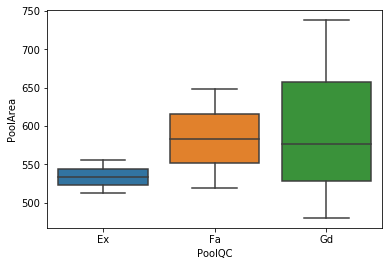

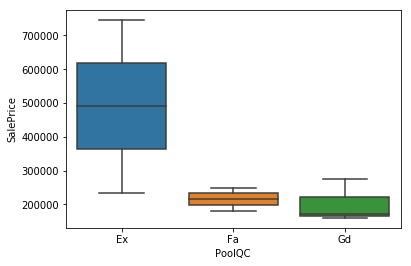

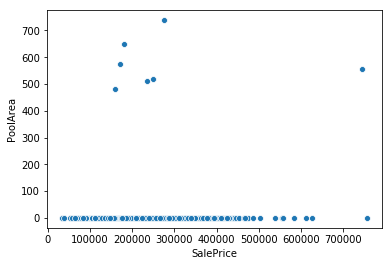

In [178]:
# Consider PoolQC
# lets see if its related to pool area
sns.boxplot(x='PoolQC', y='PoolArea', data=train_df)
plt.show()

sns.boxplot(x='PoolQC', y='SalePrice', data=train_df)
plt.show()

sns.scatterplot(x='SalePrice', y='PoolArea', data=train_df)
plt.show()

In [179]:
# we can simply say NA - NoPool
master_df['PoolQC'].fillna('NoPool', inplace=True)
print_missing(master_df)

MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageQual      0.054471
GarageFinish    0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
BsmtFinSF1      0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
Electrical      0.000343
KitchenQual     0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
GarageArea      0.000343
BsmtFinSF2      0.000343
dtype: float64


In [180]:
master_df['MiscFeature'].fillna('None', inplace=True)
print_missing(master_df)

Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageQual      0.054471
GarageFinish    0.054471
GarageCond      0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
BsmtFinSF1      0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
Electrical      0.000343
KitchenQual     0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
GarageArea      0.000343
BsmtFinSF2      0.000343
dtype: float64


In [181]:
master_df['Alley'].fillna('NoAlley', inplace=True)
print_missing(master_df)

Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageQual      0.054471
GarageFinish    0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Functional      0.000685
Utilities       0.000685
BsmtUnfSF       0.000343
BsmtFinSF1      0.000343
TotalBsmtSF     0.000343
Electrical      0.000343
KitchenQual     0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
GarageArea      0.000343
BsmtFinSF2      0.000343
dtype: float64


In [182]:
# replace NA with none
cols = ['Fence', 'FireplaceQu', 'GarageCond', 'GarageFinish',
           'GarageType', 'BsmtCond', 'BsmtExposure', 'BsmtQual',
           'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'GarageQual']
for c in cols:
    master_df[c].fillna('None', inplace=True)
print_missing(master_df)

LotFrontage     0.166495
MasVnrArea      0.007879
MSZoning        0.001370
Functional      0.000685
BsmtHalfBath    0.000685
BsmtFullBath    0.000685
Utilities       0.000685
GarageArea      0.000343
KitchenQual     0.000343
Electrical      0.000343
TotalBsmtSF     0.000343
BsmtUnfSF       0.000343
BsmtFinSF2      0.000343
BsmtFinSF1      0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
dtype: float64


In [183]:
print(master_df['LotFrontage'].describe())

# replace with median
master_df['LotFrontage'].fillna(master_df['LotFrontage'].median(), inplace=True)

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64


In [184]:
print(master_df['MasVnrArea'].describe())
# replace missing values with zero
master_df['MasVnrArea'].fillna(0, inplace=True)

count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1600.000000
Name: MasVnrArea, dtype: float64


In [185]:
# replace NA with mode
cols = ['Functional', 'MSZoning', 'Utilities',
       'KitchenQual', 'Electrical', 'Exterior2nd', 'Exterior1st']
for c in cols:
    master_df[c].fillna(master_df[c].mode()[0], inplace=True)

print_missing(master_df)

BsmtHalfBath    0.000685
BsmtFullBath    0.000685
GarageArea      0.000343
TotalBsmtSF     0.000343
BsmtUnfSF       0.000343
BsmtFinSF2      0.000343
BsmtFinSF1      0.000343
dtype: float64


In [186]:
# replace wuith zeors
cols = ['BsmtHalfBath', 'BsmtFullBath', 'GarageArea',
       'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']
for c in cols:
    master_df[c].fillna(0, inplace=True)
    
print_missing(master_df)

Series([], dtype: float64)


In [187]:
# add dummies for categorical vars
master_df = pd.get_dummies(master_df, drop_first=True)
master_df.shape

(2919, 255)

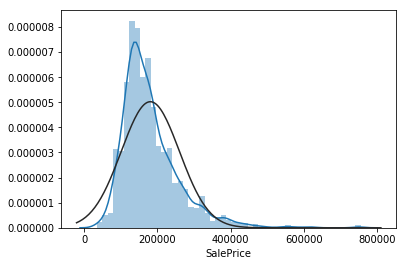

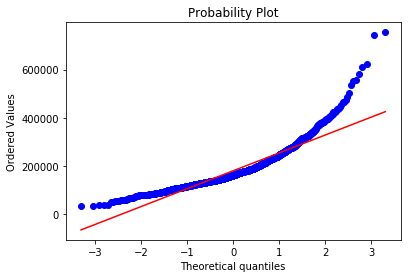

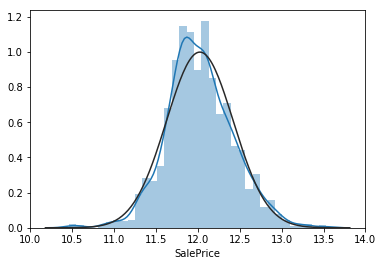

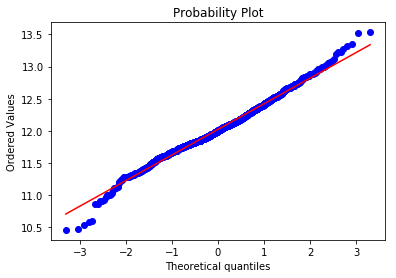

In [188]:
# plot y_train
sns.distplot(y_train, fit=norm)
plt.show()

stats.probplot(y_train, plot=plt)
plt.show()

# since it is right skewed, log transformation should help
y_train = np.log1p(y_train)

sns.distplot(y_train, fit=norm)
plt.show()

stats.probplot(y_train, plot=plt)
plt.show()

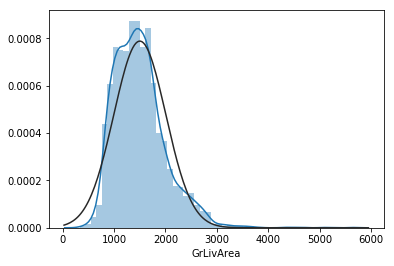

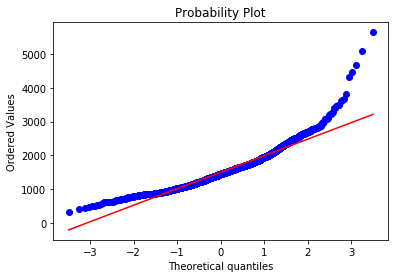

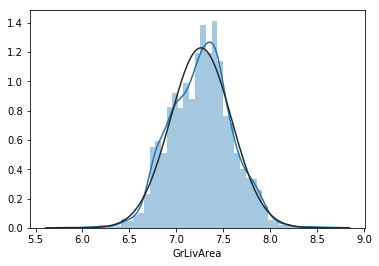

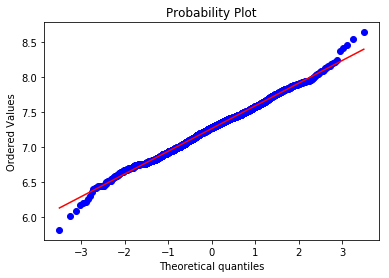

In [189]:
# plot y_train
sns.distplot(master_df['GrLivArea'], fit=norm)
plt.show()

stats.probplot(master_df['GrLivArea'], plot=plt)
plt.show()

# since it is right skewed, log transformation should help
master_df['GrLivArea'] = np.log1p(master_df['GrLivArea'])

sns.distplot(master_df['GrLivArea'], fit=norm)
plt.show()

stats.probplot(master_df['GrLivArea'], plot=plt)
plt.show()

In [190]:
X_train = master_df[:1460]
X_test = master_df[1460:]

print(X_train.shape)
print(X_test.shape)

(1460, 255)
(1459, 255)


In [114]:
from IPython.core.display import display, HTML
HTML('''<script> </script> <form action="javascript:IPython.notebook.execute_cells_above()"><input type="submit" id="toggleButton" value="Run all above Cells"></form>''')

## Modelling

In [150]:
y_train = pd.DataFrame(y_train)

In [151]:
y_train.shape

(1460, 1)

In [192]:
y_train.describe()

count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64

In [193]:
from sklearn.preprocessing import StandardScaler

xscaler = StandardScaler()
# yscaler = StandardScaler()

cols = X_train.columns
X_train = pd.DataFrame(xscaler.fit_transform(X_train), columns=cols)
# y_train = pd.DataFrame(yscaler.fit_transform(y_train))

In [194]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

param = {'alpha': [0.0001, 0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.9, 1]}
model = GridSearchCV(estimator=Lasso(),
                     param_grid=param,
                     cv=5,
                     scoring='r2')
model.fit(X_train, y_train)

/home/shakeeb/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.053573323985212085, tolerance: 0.018912592760396085
  positive)
/home/shakeeb/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034313391271117766, tolerance: 0.018002191385488822
  positive)
/home/shakeeb/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05139688972353529, tolerance: 0.018373605848561594
  positive)
/home/shakeeb/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.005, 0.01, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.9, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [195]:
print(model.best_score_)

0.8799629244739109


In [196]:
from sklearn.metrics import mean_squared_error
print(f'RMSE: {np.sqrt(mean_squared_error(model.predict(X_train), y_train))}')

RMSE: 0.11820129343907111


In [197]:
print(model.best_params_)

{'alpha': 0.005}


In [202]:
y_train.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [203]:
np.expm1(y_train).head()

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

In [205]:
X_test = xscaler.transform(X_test)
y_pred = model.predict(X_test)
y_pred[0:10]

array([11.66842837, 11.93991987, 12.08229463, 12.18878226, 12.22561348,
       12.06976443, 12.11587033, 12.01484803, 12.22930261, 11.6565099 ])

In [199]:
# y_pred_inv = yscaler.inverse_transform(y_pred)
# y_pred_inv[0:10]

In [206]:
y_pred_inv = np.expm1(y_pred)
y_pred_inv[0:10]

array([116823.53309636, 153263.40810649, 176714.1910633 , 196570.64650689,
       203945.60035034, 174513.7305091 , 182748.26025863, 165188.40913307,
       204699.37529291, 115439.42823382])

In [207]:
submission_df = test_df[['Id']]
submission_df['SalePrice'] = y_pred_inv
print(submission_df.shape)
submission_df.head()

(1459, 2)


/home/shakeeb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Id,SalePrice
0,1461,116823.533096
1,1462,153263.408106
2,1463,176714.191063
3,1464,196570.646507
4,1465,203945.600350


In [208]:
submission_df.to_csv('submission.csv', index=False)